In [18]:
import pandas as pd

# Load the data
file_path = '../T12024A2.xlsx'
sheet_name = 'Grocery+ Data'
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the dataframe
print(data.head())

# Describe the data to see the statistical summary
print(data.describe())


   Sales $m  Wages $m  No. Staff  Age (Yrs)  Adv.$'000  Competitors  \
0      12.5       2.3         60         10        171            3   
1      14.5       2.7         69          8        213            5   
2      19.0       3.1         79          7        255            2   
3      18.2       2.6         66          7        287            1   
4       7.6       2.0         51         15        112            0   

   HrsTrading  Sundays  Union%  Car Spaces  HomeDel  Mng-Gender  
0         110        0      38          46        0           0  
1         134        0      38          73        0           0  
2          98        1      39          64        0           0  
3          85        1      38          66        1           0  
4          72        1      40          29        0           0  
         Sales $m    Wages $m   No. Staff   Age (Yrs)   Adv.$'000  \
count  150.000000  150.000000  150.000000  150.000000  150.000000   
mean    11.659333    2.376667   61.4933

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Select features and target
X = data.drop('Sales $m', axis=1)
y = data['Sales $m']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the sales
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 2.5803717779154356
R^2 Score: 0.7932779067887215


## Feature Engineering

In [3]:
# Feature Engineering
data['Adv_Competitors'] = data['Adv.$\'000'] * data['Competitors']

# Update features and target after adding new feature
X = data.drop('Sales $m', axis=1)
y = data['Sales $m']

# Scaling the features
X_scaled = scaler.fit_transform(X)


## Trying Different Models

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Initialize the models
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Fit and evaluate models using cross-validation
dt_scores = cross_val_score(dt_model, X_scaled, y, cv=5, scoring='r2')
rf_scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='r2')
gb_scores = cross_val_score(gb_model, X_scaled, y, cv=5, scoring='r2')

print(f'Decision Tree R^2 Scores: {dt_scores}')
print(f'Random Forest R^2 Scores: {rf_scores}')
print(f'Gradient Boosting R^2 Scores: {gb_scores}')


Decision Tree R^2 Scores: [0.47149886 0.70736166 0.72852456 0.64497445 0.65437346]
Random Forest R^2 Scores: [0.77847184 0.8068368  0.76157079 0.80216953 0.82919771]
Gradient Boosting R^2 Scores: [0.84459929 0.79732007 0.77332415 0.80924929 0.85484989]


## Hyperparameter Tuning for GBM

In [5]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Initialize the GridSearchCV object for Gradient Boosting
gb_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), 
                              param_grid=gb_param_grid, 
                              cv=5, 
                              scoring='r2', 
                              verbose=1)

# Fit GridSearchCV
gb_grid_search.fit(X_scaled, y)
print(f'Best parameters for GBM: {gb_grid_search.best_params_}')
print(f'Best cross-validation R^2 score: {gb_grid_search.best_score_}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for GBM: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation R^2 score: 0.828523785939176


## Displaying the Best Model Parameters and Score

In [6]:
# Print the best parameters and the corresponding score
print(f'Best parameters for GBM: {gb_grid_search.best_params_}')
print(f'Best cross-validation R^2 score: {gb_grid_search.best_score_}')


Best parameters for GBM: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation R^2 score: 0.828523785939176


## Review Feature Importances

In [9]:
# Import necessary libraries
import joblib
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Assuming 'gb_grid_search' is your GridSearchCV object and 'X_scaled' and 'y' are already defined
best_gb_model = gb_grid_search.best_estimator_

# Review Feature Importances
feature_importances = best_gb_model.feature_importances_
features = X.columns
importance_frame = pd.DataFrame({
    'Feature': features, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_frame)

# Retrain the final model using the entire dataset
final_gb_model = GradientBoostingRegressor(**gb_grid_search.best_params_, random_state=42)
final_gb_model.fit(X_scaled, y)

# Save the model for deployment
model_path = 'final_gb_model.joblib'
joblib.dump(final_gb_model, model_path)

print("Model trained and saved successfully at:", model_path)


            Feature  Importance
3         Adv.$'000    0.595354
0          Wages $m    0.280568
2         Age (Yrs)    0.050845
8        Car Spaces    0.025408
1         No. Staff    0.013706
7            Union%    0.012601
9           HomeDel    0.010084
11  Adv_Competitors    0.005374
5        HrsTrading    0.005065
4       Competitors    0.000562
10       Mng-Gender    0.000357
6           Sundays    0.000075
Model trained and saved successfully at: final_gb_model.joblib


In [10]:
import joblib

# Load the model from the file
model_path = 'final_gb_model.joblib'
loaded_model = joblib.load(model_path)
print("Model loaded successfully.")


Model loaded successfully.


## Test the Model

In [11]:
from sklearn.model_selection import train_test_split

# Assuming 'X_scaled' and 'y' are still defined as your feature set and targets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Make predictions using the loaded model
predictions = loaded_model.predict(X_test)

# Optionally, print out some predictions
print("Sample predictions:", predictions[:5])


Sample predictions: [ 8.20962938  9.09719529 10.24459665 13.86780912  9.75041628]


## Evaluate the Model

In [12]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R² and MSE for the test set
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'R² Score: {r2}')
print(f'Mean Squared Error: {mse}')


R² Score: 0.9651049590420856
Mean Squared Error: 0.4355711451943297


## input data

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load the model and the scaler
model_path = 'final_gb_model.joblib'
loaded_model = joblib.load(model_path)

# Prepare input data (ensure you match this structure to your model's features)
data = {
    'Wages $m': [2.5],        # Enter the actual wage value here
    'No. Staff': [70],        # Enter the actual number of staff here
    'Age (Yrs)': [10],        # Enter the age of the store here
    'Adv.$\'000': [150],      # Enter the actual advertising budget here
    'Competitors': [3],       # Enter the number of competitors here
    'HrsTrading': [100],      # Enter the trading hours here
    'Sundays': [1],           # 1 if open on Sundays, 0 otherwise
    'Union%': [30],           # Enter the percentage of unionized employees here
    'Car Spaces': [50],       # Enter the number of car spaces here
    'HomeDel': [1],           # 1 if home delivery is offered, 0 otherwise
    'Mng-Gender': [0],        # 0 for male, 1 for female manager
    'Adv_Competitors': [100]  # Enter the actual advertising to competitors ratio here
}


input_df = pd.DataFrame(data)

# Scale the input data using the pre-trained scaler
# Make sure to use the same scaler used in training the model
scaled_input = scaler.transform(input_df)

# Make predictions
predictions = loaded_model.predict(scaled_input)
print("Predicted Sales $m:", predictions[0])


Predicted Sales $m: 12.353168813978249


In [16]:
pip install matplotlib seaborn

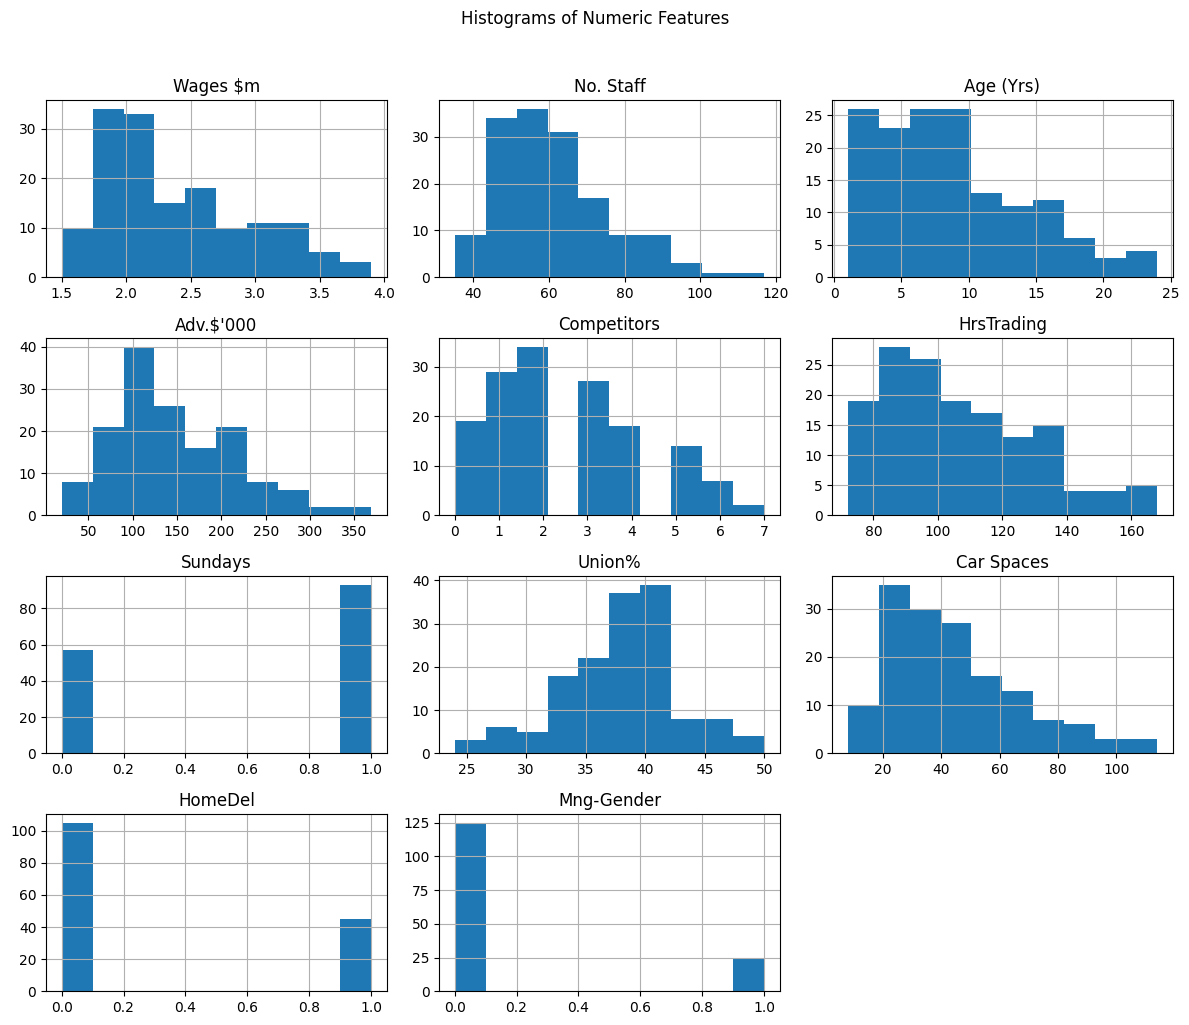

In [23]:
import pandas as pd

# Load your data from Excel into a DataFrame, specifying the sheet name
sheet_name = 'Grocery+ Data'  # Specify the name of the sheet containing your data
df = pd.read_excel('../T12024A2.xlsx', sheet_name=sheet_name)

# Now you can proceed with the visualization code
# Plot histograms for numeric features
numeric_features = ['Wages $m', 'No. Staff', 'Age (Yrs)', 'Adv.$\'000', 'Competitors', 
                    'HrsTrading', 'Sundays', 'Union%', 'Car Spaces', 'HomeDel', 'Mng-Gender']
df[numeric_features].hist(figsize=(12, 10))
plt.suptitle('Histograms of Numeric Features', y=1.02)
plt.tight_layout()
plt.show()



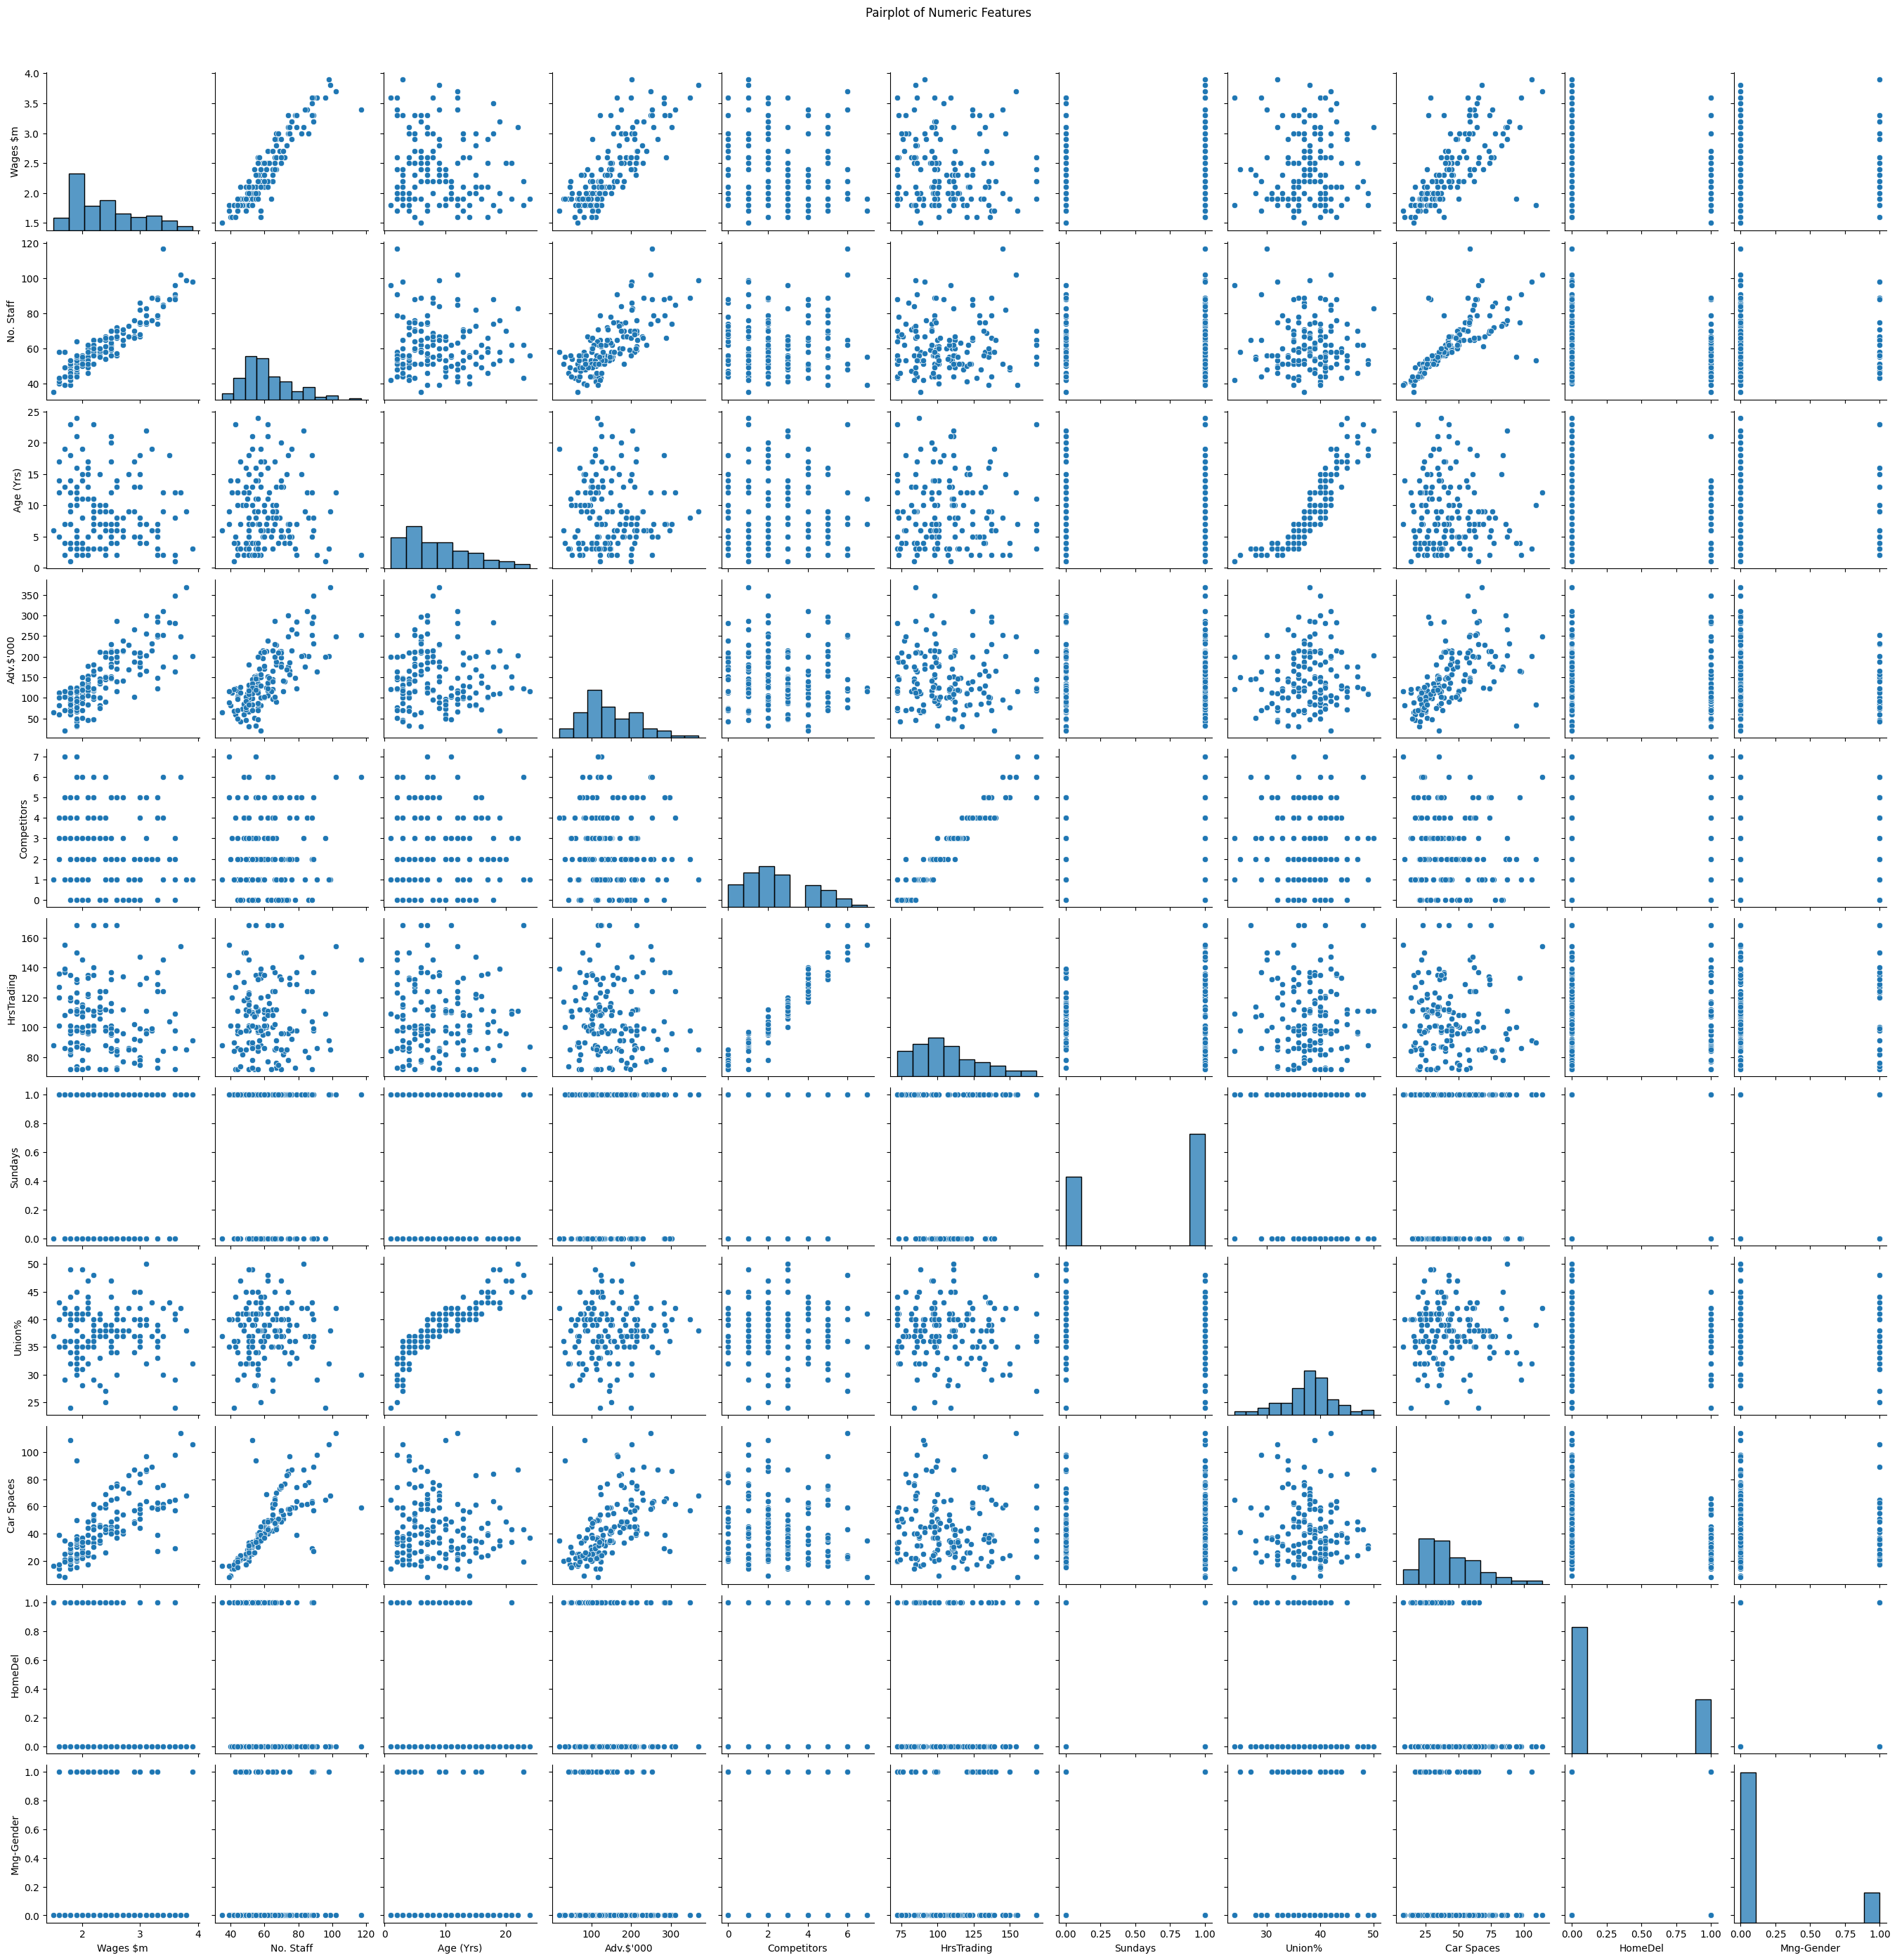

In [25]:
import warnings
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")
# Pairplot for visualizing relationships between features
sns.pairplot(df[numeric_features])
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()



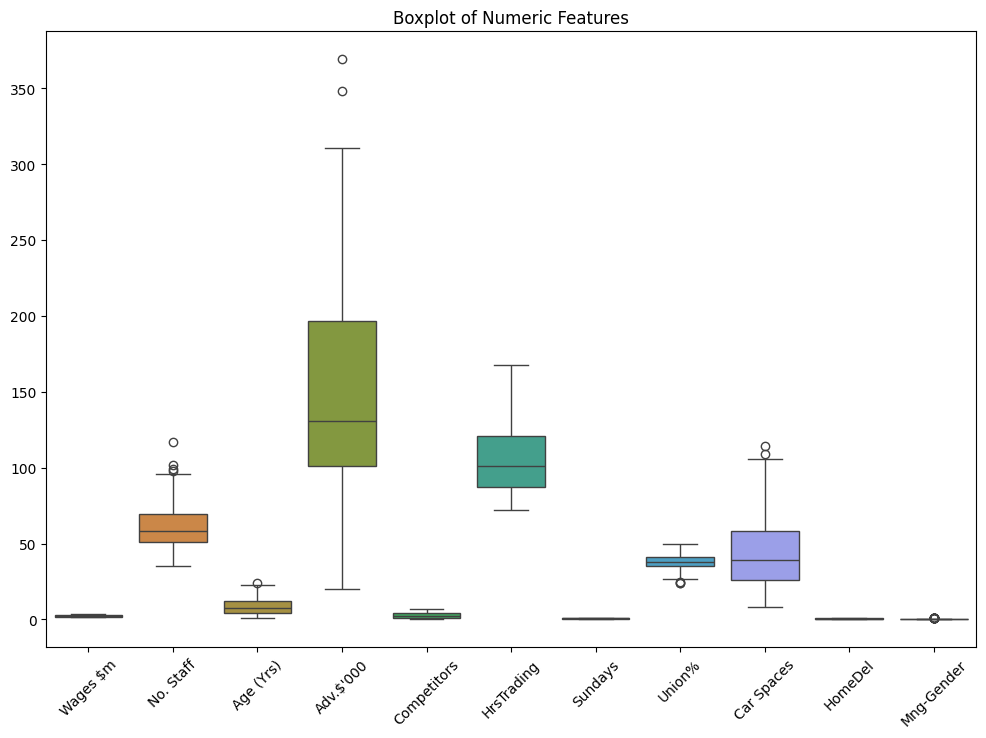

In [26]:
# Boxplot for visualizing distributions and outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numeric_features])
plt.title('Boxplot of Numeric Features')
plt.xticks(rotation=45)
plt.show()




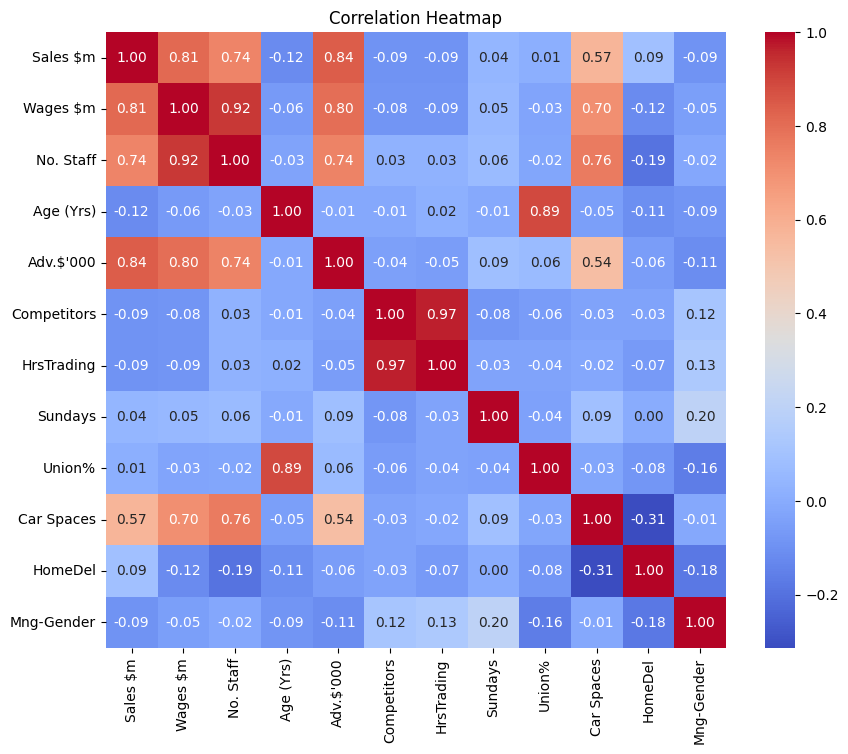

In [27]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()